# Caffeine Consumption through a GWAS Lens

BIO-373: Practical Evaluation, Part 1 November 25 2024  
Viola Renne

## 1) Setting the environment

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
import statsmodels.api as sm
import re

In [2]:
# Read annotations
annotations_path = 'data/annotations.txt'
annotations_df = pd.read_csv(annotations_path, sep='\t')
print("The number of samples in the annotation.txt file is {}".format(annotations_df.shape[0]))

The number of samples in the annotation.txt file is 3500


In [3]:
# Read genotypes
genotypes_path = 'data/genotypes.vcf'
genotypes_df = pd.read_csv(genotypes_path, sep='\t', skiprows=2, low_memory=False)
print("The number of samples in the genotypes.vcf file is {} for {} variants".format(genotypes_df.shape[1] - 9, genotypes_df.shape[0]))

The number of samples in the genotypes.vcf file is 284 for 10879 variants


In [4]:
# Drop columns that are not used
genotypes_df.drop(['ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1, inplace=True)

# Remove AD:DP:GQ:PL to maintain only genotype information
genotypes_df.iloc[:, 2:] = genotypes_df.iloc[:, 2:].map(lambda x: re.findall(r'^(?:0|1|\.)/(?:0|1|\.)', x)[0])

### 1.a) Exploratory data analysis 

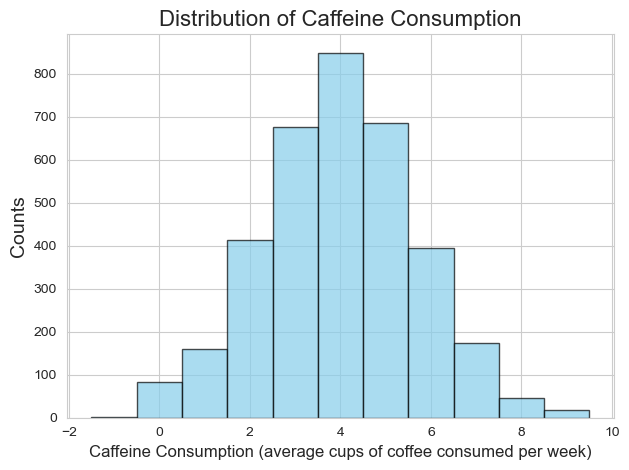

In [5]:
# Plot a histogram of caffeine consumption
min_value = annotations_df['CaffeineConsumption'].min()
max_value = annotations_df['CaffeineConsumption'].max()
bin_edges = np.arange(min_value - 0.5, max_value + 0.5, 1)
plt.hist(annotations_df['CaffeineConsumption'], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Caffeine Consumption', fontsize=16)
plt.xlabel('Caffeine Consumption (average cups of coffee consumed per week)', fontsize=12)
plt.ylabel('Counts', fontsize=14)
plt.tight_layout()
plt.savefig('figures/caffeine_consumption_distribution.png')
plt.show()

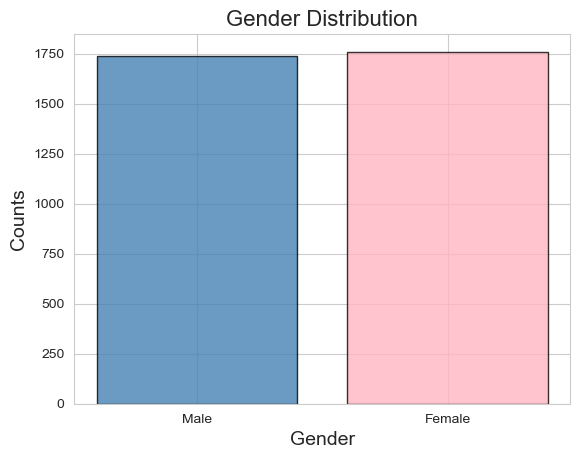

In [6]:
# Plot a bar plot of gender
genders = ['Male', 'Female']
counts = [annotations_df['isFemale'].value_counts()[False], annotations_df['isFemale'].value_counts()[True]]

plt.bar(genders, counts, color=['steelblue', 'lightpink'], edgecolor='black', alpha=0.8)
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.savefig('figures/gender_distribution.png')
plt.show()

## 2) SNP-level filtering: call rate

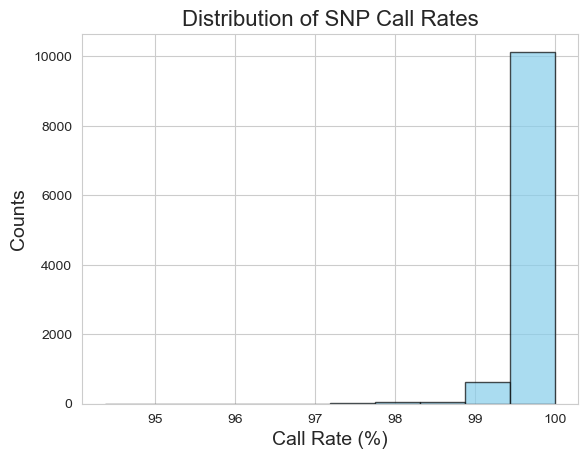

In [7]:
# Calculate the call rate for each SNP
call_rates = (1 - (genotypes_df.iloc[:, 2:] == './.').astype(int)).mean(axis=1) * 100

# Plot the histogram of call rates
plt.hist(call_rates, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of SNP Call Rates', fontsize=16)
plt.xlabel('Call Rate (%)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.savefig('figures/snp_call_rates_distribution.png')
plt.show()

In [8]:
# Keep variants whose call rate is equal to 100%
labels = call_rates < 100
genotypes_df_filtering_1 = genotypes_df.drop(labels[labels].index, axis=0)

# Count remove variants
print("The removed variants are {}".format((labels.value_counts()[True])))

The removed variants are 2888


## 3) SNP-level filtering: minor allele frequency (MAF)

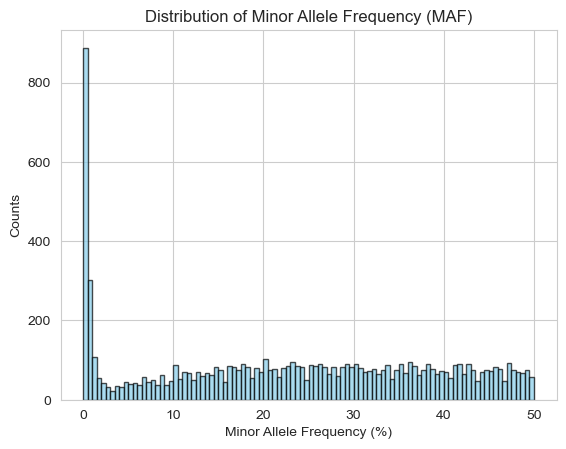

In [9]:
# Calculate MAF for each variant
mapping = {'0/0': 0, 
           '0/1': 1, 
           '1/0': 1,
           '1/1': 2}

genotypes_df_filtering_1.iloc[:, 2:] = genotypes_df_filtering_1.iloc[:, 2:].apply(lambda x: x.map(mapping))
maf_values = genotypes_df_filtering_1.iloc[:, 2:].apply(lambda x: min(x.mean()/2, 1 - x.mean()/2), axis=1) * 100 

# Plot MAF histogram
plt.hist(maf_values, bins=100, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Minor Allele Frequency (%)')
plt.ylabel('Counts')
plt.title('Distribution of Minor Allele Frequency (MAF)')
plt.savefig('figures/maf_distribution.png')
plt.show()

In [10]:
# Remove all the variants whose MAF is less than or equal to 1%
labels = maf_values <= 1
genotypes_df_filtering_2 = genotypes_df_filtering_1.drop(labels[labels].index, axis=0)

print("The removed variants are {}".format((labels.value_counts()[True])))

The removed variants are 1189


## 4) Genome-Wide Association Studies

### 4a) Explore the potential effect of gender on the phenotype

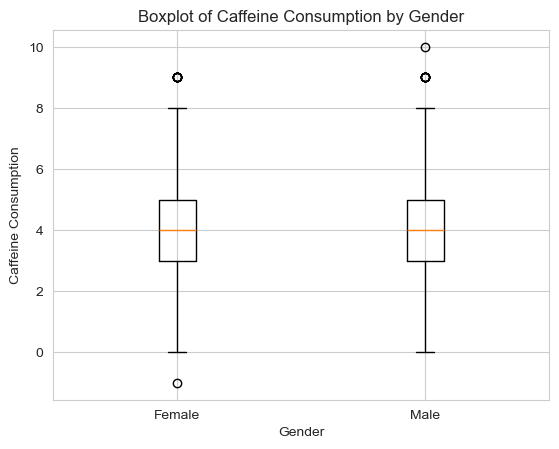

In [11]:
# i. Plot a boxplot showing the distribution of caffeine consumption by gender
caffeine_consumption_gender = [list(annotations_df[annotations_df['isFemale'] == True]['CaffeineConsumption']), list(annotations_df[annotations_df['isFemale'] == False]['CaffeineConsumption'])]

plt.boxplot(caffeine_consumption_gender)
plt.title('Boxplot of Caffeine Consumption by Gender')
plt.xticks([1, 2], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Caffeine Consumption')
plt.savefig('figures/caffeine_consumption_by_gender_boxplot.png')
plt.show()

/Users/violarenne/opt/anaconda3/envs/Genomics/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/violarenne/opt/anaconda3/envs/Genomics/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


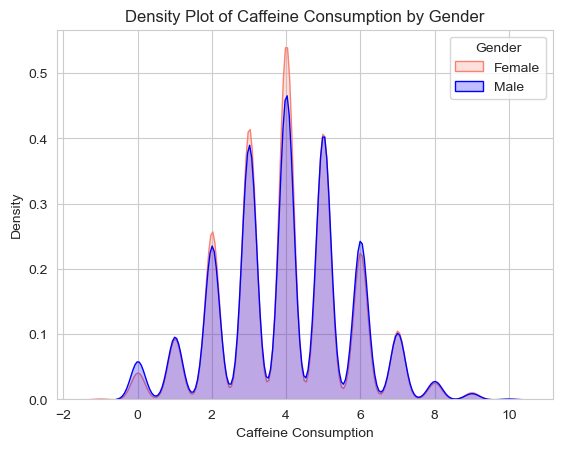

In [12]:
# Plot a density plot showing the distribution of caffeine consumption by gender
sns.kdeplot(caffeine_consumption_gender[0], label='Female', fill=True, color='salmon', bw_adjust=0.5)
sns.kdeplot(caffeine_consumption_gender[1], label='Male', fill=True, color='blue', bw_adjust=0.5)
plt.title('Density Plot of Caffeine Consumption by Gender')
plt.xlabel('Caffeine Consumption')
plt.ylabel('Density')
plt.legend(title='Gender')
plt.savefig('figures/caffeine_consumption_by_gender_densityplot.png')
plt.show()

The box plot shows that there is no notable difference in the distribution of caffeine consumption between genders.

In [13]:
# ii. Linear regression between phenotype (caffeine consumption) and the covariate (gender)
X = annotations_df[['isFemale']]
y = annotations_df[['CaffeineConsumption']]
reg = LinearRegression().fit(X, y)

# Print coefficients of the model and the Coefficient of Determination (R2)
print('The intercept of the model is {:.3f} and the slope is {:.3f}. The Coefficient of Determination is {:.5f}.'.format(reg.intercept_[0], reg.coef_[0][0], reg.score(X, y)))

The intercept of the model is 3.991 and the slope is -0.015. The Coefficient of Determination is 0.00002.


Given that the coefficient is close to zero and the $R^2$ value is also near zero, we can conclude that there is no relationship between caffeine consumption and gender.

We should not include gender as a covariate in our analysis since the previous results show no relationship between gender and caffeine consumption. Including it would add unnecessary complexity to the model without contributing to explanatory power.

### 4b) Population structure

In [14]:
# i. Calculate the principal components (PCs) of the genotype matrix
matrix = genotypes_df_filtering_2.iloc[:, 2:].T
pca = decomposition.PCA(n_components=2)
pca.fit(matrix)
transformed_data = pca.transform(matrix)
transformed_df = pd.DataFrame(transformed_data, index=matrix.index, columns=['PC1', 'PC2'])
result_df = pd.merge(transformed_df, annotations_df, how='left', left_index=True, right_on='Sample')

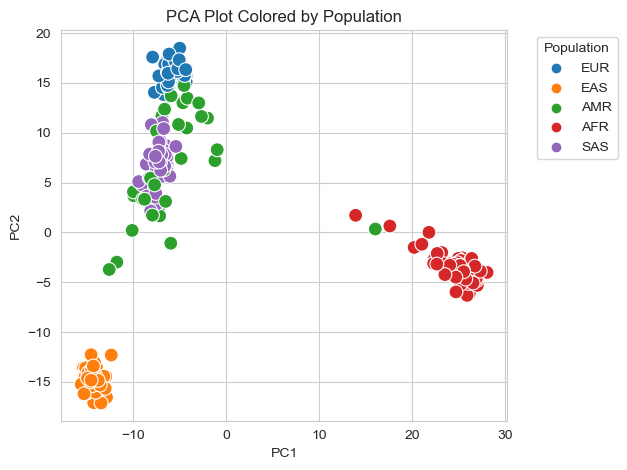

In [15]:
# Plot the first and second principal components
sns.scatterplot(data=result_df, x='PC1', y='PC2', hue='SuperPopulation', palette='tab10', s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot Colored by Population')
plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('figures/pca.png')
plt.show()

There are three clusters, each representing different subpopulations. The first cluster (in orange) corresponds to East Asians, the second (blue, purple and green) to Europeans, Ad Mixed Americans, and South Asians, while the third cluster (red) represents Africans.

We should account for population structure. This because different populations can have distinct genetic or environmental characteristics. If we do not adjust for population structure, these differences might confound the relationship between the variables being studied. Correcting for population structure ensures that the associations we observe are not driven by differences between populations.

### 4c) GWAS without correcting for covariates 

In [16]:
def linear_regression_model(data, y, snps, positions, columns=None):
    """
    Compute linear regression for the all the SNPs in snps
    :param data: data from where X will be extracted.
    :param y: dependent variable.
    :param snps: list of SNPs for which linear regression will be performed.
    :param positions: information on chromosomes and positions for each SNP.
    :param columns: columns to extract from the data other than the snp.
    :return: DataFrame containing the snps, coefficients and p-values.
    """
    if columns is None:
        columns = []
    
    model_results = {}
    for snp in snps:
        X_const = sm.add_constant(data[[snp] + columns], has_constant='raise')
        model = sm.OLS(y.astype(float), X_const.astype(float)).fit()
        # Extract at each iteration of the loop the coefficient of association (β) between the variant and the phenotype and the corresponding p-value
        model_results[snp] = {
            'p_value': model.pvalues[snp],
            'coefficients': model.params[snp],
            '#CHROM': positions.loc[snp, '#CHROM'],
            'POS': positions.loc[snp, 'POS']
        }
        
    model_results_df = pd.DataFrame([
        {'SNP': snp, 
         'Coefficient': result['coefficients'],
         'P-Value': result['p_value'],
         '#CHROM': result['#CHROM'],
         'POS': result['POS']
         }
        for snp, result in model_results.items()
    ])
    
    return model_results_df

In [17]:
# Linear regression to test for the association between the variants and the phenotype
data_snps = pd.merge(matrix, annotations_df, how='left', left_index=True, right_on='Sample')
snp_columns = matrix.columns
summary_df = linear_regression_model(data_snps, data_snps[['CaffeineConsumption']], snp_columns, genotypes_df_filtering_2[['#CHROM', 'POS']])

### 4d) Manhattan Plot

In [18]:
def manhattan_plot(df, threshold, title, name):
    """
    Plot Manhattan Plot
    :param df: DataFrame with the SNPs, P-values and Colors.
    :param threshold: Bonferroni correction of the threshold.
    :param title: additional part for the title.
    :param name: name to use for saving the plots.
    """
    # Define the colours of the plot
    colors = ['blue', 'red']
    chromosomes = df['#CHROM'].unique()
    chromosome_colors = {chrom: colors[i % len(colors)] for i, chrom in enumerate(chromosomes)}
    df['Color'] = df['#CHROM'].map(chromosome_colors)
    df.loc[df['P-Value-log'] > threshold, 'Color'] = 'green'
        
    # Add chromosome labels to the x-axis
    tick_labels = [f'{chrom}' for chrom in chromosomes]
    tick_positions = []
    for chrom in chromosomes:
        chrom_data = df[df['#CHROM'] == chrom]
        tick_positions.append(chrom_data.index[len(chrom_data) // 2])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(df.index, df['P-Value-log'], c=df['Color'])
    ax.axhline(threshold, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(P)')
    ax.set_title('Manhattan Plot' + title)
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    # Leave only horizontal line in the grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', visible=False)
    
    plt.tight_layout()
    plt.savefig('figures/' + name)
    plt.show()

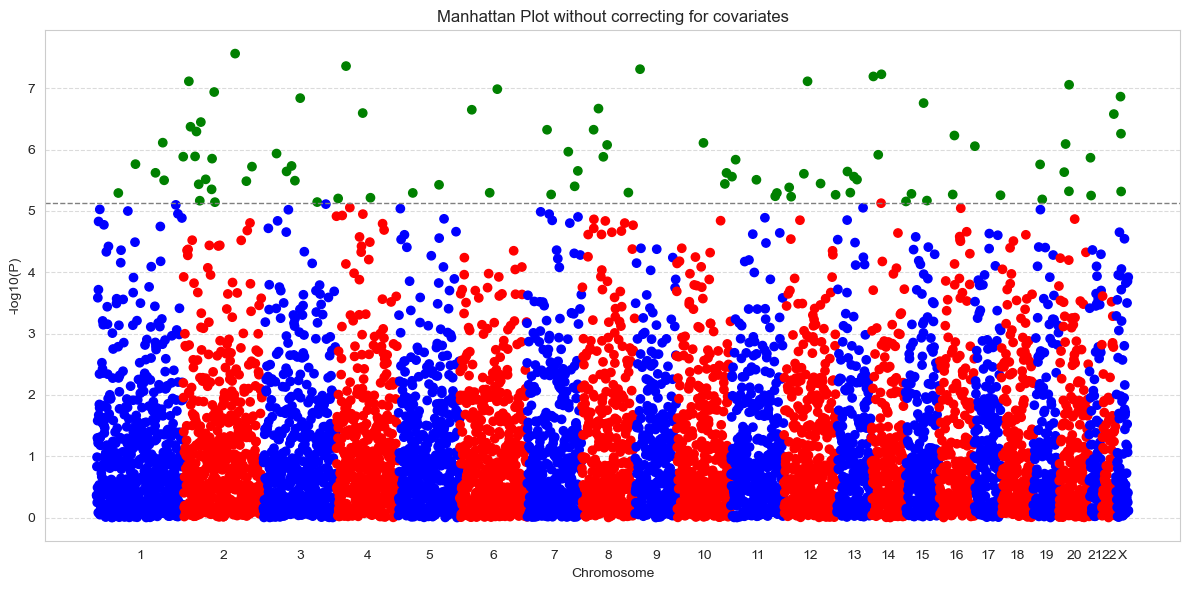

In [19]:
# Compute the -log10 value of pvalues
summary_df['P-Value-log'] = summary_df['P-Value'].apply(lambda x: -np.log10(x))

# Compute the corrected significant threshold using Bonferroni
alpha = 0.05
bonferroni_threshold = -np.log10(alpha / len(snp_columns))

manhattan_plot(summary_df, bonferroni_threshold, ' without correcting for covariates', 'manhattan_plot_no_covariates.png')

Many SNPs result to be above the threshold. This can be attributed to the lack of correction for confounding factors, such as population structure. Without accounting for these factors, false positives can occur, as seen in this case.

### 4e) GWAS with 10 principal components

In [20]:
# PCA with 10 principal components
pca = decomposition.PCA(n_components=10, random_state=42)
pca.fit(matrix)
transformed_data = pca.transform(matrix)
transformed_df = pd.DataFrame(transformed_data, index=matrix.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

data_snps_10 = pd.merge(data_snps, transformed_df, left_on='Sample', right_index=True, how='left')
# Linear regression to test for the association between the variants and the phenotype
summary_df_pc = linear_regression_model(data_snps_10, data_snps_10[['CaffeineConsumption']], snp_columns,  genotypes_df_filtering_2[['#CHROM', 'POS']], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

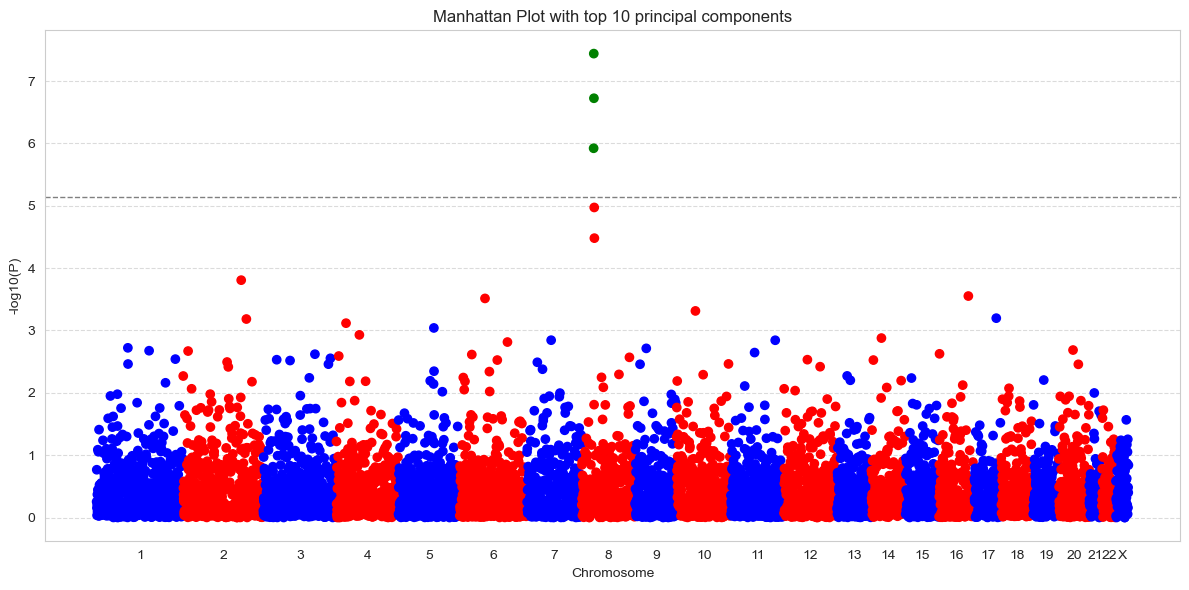

In [21]:
# Apply -log10 on the p values
summary_df_pc['P-Value-log'] = summary_df_pc['P-Value'].apply(lambda x: -np.log10(x))

# Plot Manhattan plot
manhattan_plot(summary_df_pc, bonferroni_threshold, ' with top 10 principal components', 'manhattan_plot_pcs.png')

Correcting for the top 10 PCs results in fewer SNPs above the threshold. This is because we are now accounting for covariates, which reduces the number of false positives.

### 4f) GWAS with SuperPopulation 

In [22]:
# One hot encoding of SuperPopulation
data_snps_sp = pd.get_dummies(data_snps, columns=['SuperPopulation'], drop_first=True)
data_snps_sp[['SuperPopulation_AMR', 'SuperPopulation_EAS', 'SuperPopulation_EUR', 'SuperPopulation_SAS']] = data_snps_sp[['SuperPopulation_AMR', 'SuperPopulation_EAS', 'SuperPopulation_EUR', 'SuperPopulation_SAS']].astype(int)
# Perform linear regression
summary_df_sp = linear_regression_model(data_snps_sp, data_snps_sp[['CaffeineConsumption']], snp_columns,genotypes_df_filtering_2[['#CHROM', 'POS']], columns=['SuperPopulation_AMR', 'SuperPopulation_EAS', 'SuperPopulation_EUR', 'SuperPopulation_SAS'])

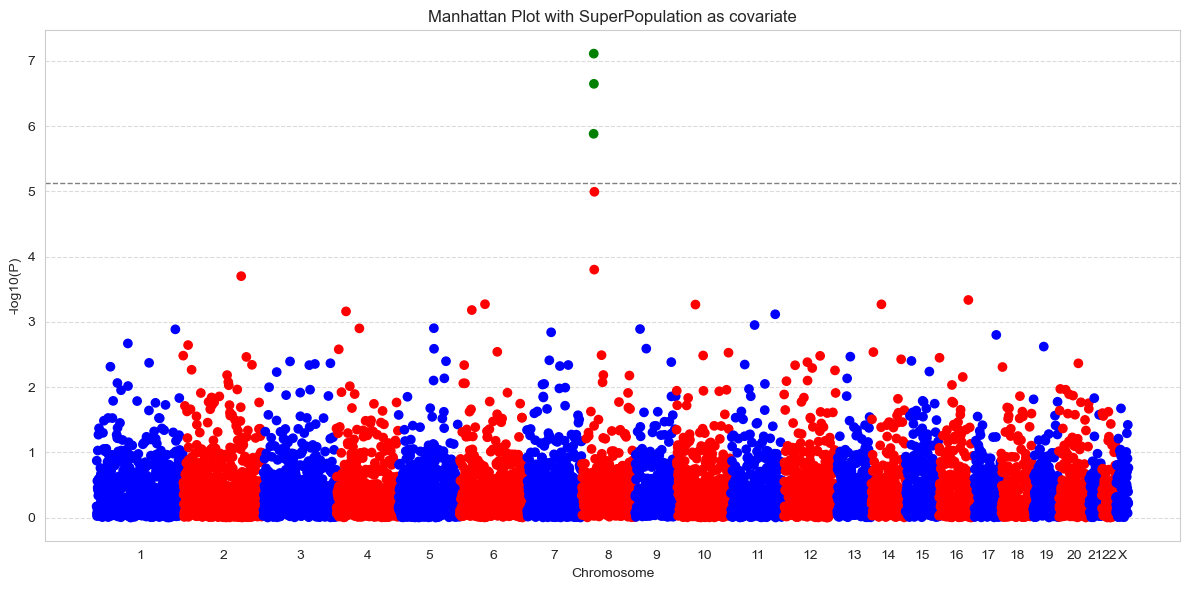

In [23]:
# -log10 scale of Pvalues
summary_df_sp['P-Value-log'] = summary_df_sp['P-Value'].apply(lambda x: -np.log10(x))

# Manhattan Plot
manhattan_plot(summary_df_sp, bonferroni_threshold, ' with SuperPopulation as covariate', 'manhattan_plot_population.png')

Just like when correcting for the top 10 PCs, incorporating ethnicities as a covariate reduce the number of SNPs that appear significant. We still observe the same three SNPs above the threshold.

Overall, using PCs is preferable as they capture both large and small genetic differences across populations. Ethnicities may not account for all the relevant genetic variation within the sample.

## 5) Functional Analysis

In [24]:
# Find the most significant SNP
summary_df_pc.loc[summary_df_pc['P-Value-log'] == summary_df_pc['P-Value-log'].max(), ['#CHROM', 'POS', 'P-Value-log', 'SNP']]

,#CHROM,POS,P-Value-log,SNP
3277,8,19619751,7.440706,5112


The variants rsID is rs4262337. Using Open Target Genomics, the top associated gene with this variant is INTS10.
The evidences used to find this association are:
1) changes in gene splicing
2) changes in gene expression

## 6) QQ Plots

In [25]:
def qq_plots(observed_p_values, title):
    observed_p_values = np.sort(observed_p_values)
    n = len(observed_p_values)
    expected_p_values = (np.arange(n, dtype=float) + 1 - 0.5) / (n + 1 - 2 * 0.5)
    expected_p_values = np.sort(expected_p_values)
    
    plt.scatter(-np.log10(expected_p_values), -np.log10(observed_p_values), color='blue', alpha=0.6)
    plt.plot([-np.log10(expected_p_values).min(), -np.log10(observed_p_values).max()],
             [-np.log10(expected_p_values).min(), -np.log10(observed_p_values).max()],
             color='red', linestyle='--')
    plt.xlabel('Expected -log10(p)')
    plt.ylabel('Observed -log10(p)')
    plt.title('Q-Q Plot of GWAS Results' + title)
    plt.show()

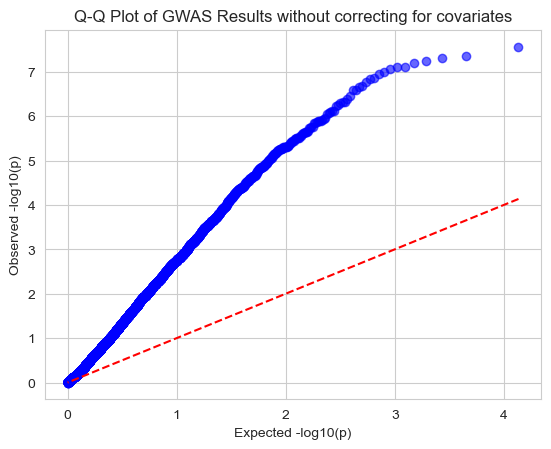

In [26]:
qq_plots(np.array(summary_df['P-Value']), " without correcting for covariates")

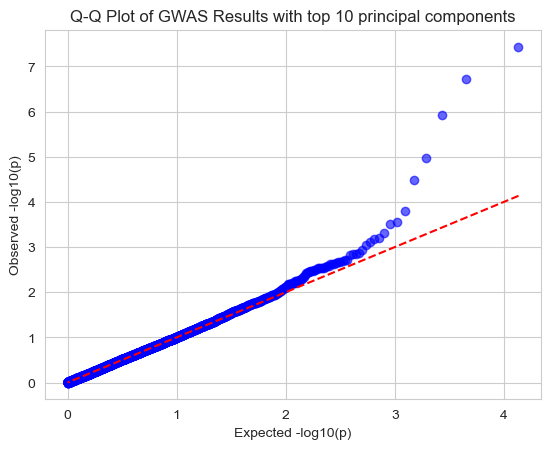

In [27]:
qq_plots(np.array(summary_df_pc['P-Value']), ' with top 10 principal components')

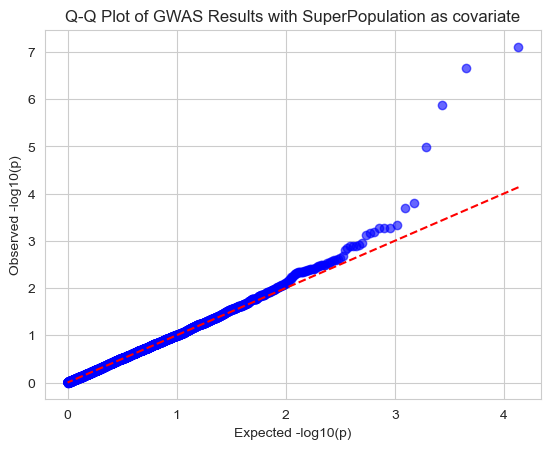

In [28]:
qq_plots(np.array(summary_df_sp['P-Value']), ' with SuperPopulation as covariate')

Q-Q plots are used for quality control checks, because they assess if there are any systematic biases or population stratification in the data. In particular, Q-Q plots illustrate the relationship between the observed distribution of p-values (y-axis) and the expected distribution by chance (x-axis). 
In an ideal Q-Q plot, the points should follow the reference line (red line), indicating that the observed data matches the expected distribution. We can see that this is not the case for the first plot. This is due to the fact that we did not correct for the population.
Deviations in the tail of the plot, where the observed statistics diverge from the expected ones, suggest potential associations. This is what we see in the last two plots (when correcting using PCs or SuperPopulation).